In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
!pip install  dgl -q -f https://data.dgl.ai/wheels/cu118/repo.html
!pip install  dglgo -q -f https://data.dgl.ai/wheels-test/repo.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.1/112.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 116.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 54.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.7/572.7 kB 53.4 MB/s eta 0:

In [ ]:
import os
os.environ["DGLBACKEND"] = "pytorch"

import dgl
import torch
import torch.nn.functional as F

# Graph Data Process

本章節我們會介紹如何在 dgl 中批次讀取圖的結構信息，dgl 的架構類似 pytorch，我們必須自定義一個類別，並繼承於 `DGLDataset` 類，具體需要設置的方法如下

在設置中，有幾個方法是**一定要設定的**，

- `__init__():` 資料初始化階段，我們通常在這裡指定資料集的路徑
- `process():` 我們會再這邊處理圖的原始數據轉成 dgl 支援的形式 (圖,圖標籤)，dgl 會**自動調用該方法**處理數據
- `__getitem__(idx):` 傳入一個 index, 我們會取出對應該 index 的圖和圖的全局信息
- `__len__():` 資料總共有幾張圖

另外有一些參數雖然不是必須設置的，但 dgl 也推薦實現該方法



In [ ]:
from dgl.data import DGLDataset

class MyDataset(DGLDataset):
    """ 用于在DGL中自定义图数据集的模板：

    Parameters
    ----------
    url : str
        下载原始数据集的url。
    raw_dir : str
        指定下载数据的存储目录或已下载数据的存储目录。默认: ~/.dgl/
    save_dir : str
        处理完成的数据集的保存目录。默认：raw_dir指定的值
    force_reload : bool
        是否重新导入数据集。默认：False
    verbose : bool
        是否打印进度信息。
    """
    def __init__(self,
                 url=None,
                 raw_dir=None,
                 save_dir=None,
                 force_reload=False,
                 verbose=False):
        super(MyDataset, self).__init__(name='dataset_name',
                                        url=url,
                                        raw_dir=raw_dir,
                                        save_dir=save_dir,
                                        force_reload=force_reload,
                                        verbose=verbose)

    def download(self):
        # 将原始数据下载到本地磁盘
        pass

    def process(self):
        # 将原始数据处理为图、标签和数据集划分的掩码
        pass

    def __getitem__(self, idx):
        # 通过idx得到与之对应的一个样本
        pass

    def __len__(self):
        # 数据样本的数量
        pass

    def save(self):
        # 将处理后的数据保存至 `self.save_path`
        pass

    def load(self):
        # 从 `self.save_path` 导入处理后的数据
        pass

    def has_cache(self):
        # 检查在 `self.save_path` 中是否存有处理后的数据
        pass

## GraphDataLoader

有了上面的介紹，我們已經知道怎麼實現 `GraphDataset` 了，接下來我們要批次讀取這些圖，我們可以透過 API `GraphDataLoader` 來實現

- `GraphDataLoader(dataset, batch_size, shuffle, drop_last, graph_sampler, collate_fn, use_ddp, ddp_seed)`
   - `dataset->DGLDataset:` 自訂義圖類，必須繼承於 `DGLDataset`
   - `batch_size->Int:` 批次讀取圖的數量
   - `shuffle->Bool:` 將圖的順序打亂
   - `graph_sampler->func:` 圖的抽樣函數
   - `collate_fn->func:` 對批次的圖進行調整
   - `use_ddp->Bool:` 是否使用分布式多進程 (單機多卡、多機多卡)
   - `ddp_seed:` 多進程隨機種子

### 讀取資料
`GraphDataLoader` 具體怎麼實現 GNN 批次讀取圖資料呢? 其實現是繼承於 `torch.utils.data.DataLoader`，具體流程如下

- `sampler:` 抽樣方式
- `dataset:` 對圖的處理方法
- `collate_fn:` 對一個批次進行整合

具體流程如下:

sampler --> indices --> dataset --> collate_fn

#### Unpacking

graphdataloader 是個 Iterator，回傳 `(batched_graph, labels)` 的元組

- `batched_graph:` 一個批次的圖
- `labels:` 圖對應的標籤

graphdataloader 對於 `batched_graph` 的處理方式很高效，接下來我們介紹 dgl 怎麼批次讀取圖的資料

#### Batch

與其給你 n 張圖，dgl 透過 `batch` API 把 n 張圖結合成一張大圖，但若你非得要 n 張圖，也可以透過 `unbatch` API 將大圖還原成子圖喔

![](https://data.dgl.ai/tutorial/batch/batch.png)

這個大圖每個連通子圖都對著原始資料的一張小圖，那麼這麼做的好處是什麼呢?

<details>
<summary>好處是什麼呢? 點擊查看解答</summary>
由於子圖之間是非連通的，因此 Message passing 可以獨立的在各個子圖上傳遞，因此我們只需要執行一次 message passing 便可以在 n 張圖上進行消息傳遞
</details>

#### Inference

在整圖上的推斷，我們會基於圖的全局信息進行判斷，那麼要如何得到圖的全局信息呢? 有很多種方法，這裡我們介紹最簡單的一種，把圖中所有頂點的特徵進行匯聚，作為圖的全局信息 (這種方法會遺失邊的信息)，我們可以透過以下方法實現 `dgl.readout_nodes(g, "attr")` 該方法回傳大小為 `(batch_size, node_embedding_dims)` 大小的 tensor

In [ ]:
dataset = dgl.data.GINDataset('MUTAG', False)
dataloader = dgl.dataloading.GraphDataLoader(
    dataset,
    batch_size=8,
    drop_last=False,
    shuffle=True)

Extracting file to /root/.dgl/GINDataset


In [ ]:
batched_graph, labels = next(iter(dataloader))
dim = dgl.readout_nodes(batched_graph, "attr").shape

/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In [ ]:
print("Total graph: ", dataset.__len__())
print(f"Batched graph: {batched_graph}")
print(f"Subgraphs: {dgl.unbatch(batched_graph)}")
print(f"Number of nodes in subgraphs: {batched_graph.batch_num_nodes()}")
print(f"Number of edges in subgraphs: {batched_graph.batch_num_edges()}")
print(f"Global-context dimension: {dim}")

Total graph:  188
Batched graph: Graph(num_nodes=128, num_edges=276,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(7,), dtype=torch.float32)}
      edata_schemes={})
Subgraphs: [Graph(num_nodes=13, num_edges=28,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(7,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=15, num_edges=34,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(7,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=14, num_edges=28,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(7,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=17, num_edges=38,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(7,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=19, num_edges=42,
      ndata_schemes={'label': Scheme(shape=()

有了整圖的全局信息，我們就可以實現整圖的下游任務了!! 總的來說，具體步驟如下

![](https://data.dgl.ai/tutorial/batch/graph_classifier.png)

1. 根據批次圖處理 dataset
2. 實例化 graphdataloader
3. 在批次圖上更新節點和邊的特徵，最後匯聚成全局信息
4. 根據不同的下游任務設計不同的頭部 (Head)

## Subgraph

`GraphDataLoader` 實現了批次讀取圖的信息，但是當我們只有**一張圖**或者我想要**批次讀取圖中的點或者邊的信息**呢? 這時候就需要引入子圖的概念，有了子圖概念後，我們會使用 `DataLoader` 批次讀取圖的節點或邊信息

再取出子圖後，dgl 會對子圖中的點和邊進行 ID 重排，所以我們無法直接對應子圖的 ID 和原圖的 ID，因此必須透過 `dgl.NID` 和 `dgl.EID` 去取出子圖對應原圖的那些節點和邊

### node_subgraph

`node_graph` 根據節點 ID 去取出子圖，用法如下

`node_graph(graph, nodes)`
   - `graph:` 要取出的原圖
   - `nodes:` 要取出的節點 ID

Origin Graph: Graph(num_nodes=5, num_edges=5,
      ndata_schemes={}
      edata_schemes={})
Sampled Subgraph: Graph(num_nodes=3, num_edges=2,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})
Original node IDs: tensor([0, 1, 4])
Subgraph node IDs: tensor([0, 1, 2])
Original edge IDs: tensor([0, 4])


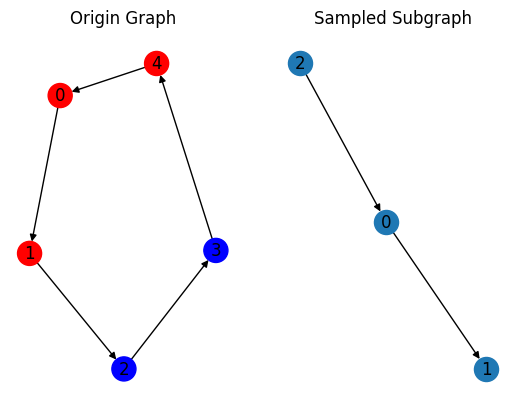

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
def display_graph(graph, subgraph, sample_by="node"):
  assert sample_by in ["node", "edge"]
  if sample_by == "node":
    origin_ids = subgraph.ndata[dgl.NID]
    color = ["red" if i in origin_ids else "blue" for i in range(graph.num_nodes())]
  else:
    origin_ids = subgraph.edata[dgl.EID]
    color = ["red" if i in origin_ids else "blue" for i in range(graph.num_edges())]
  graph, subgraph = graph.to_networkx(), subgraph.to_networkx()
  plt.subplot(1,2,1)
  plt.axis("off")
  plt.title("Origin Graph")
  if sample_by == "node":
    nx.draw(graph, with_labels=True, node_color=color)
  else:
    nx.draw(graph, with_labels=True, edge_color=color)
  plt.subplot(1,2,2)
  plt.axis("off")
  plt.title("Sampled Subgraph")
  nx.draw(subgraph, with_labels=True)

def display_info(graph, subgraph):
  print(f"Origin Graph: {graph}")
  print(f"Sampled Subgraph: {subgraph}")
  try:
    print(f"Original node IDs: {subgraph.ndata[dgl.NID]}")
  except:
    pass
  print(f"Subgraph node IDs: {subgraph.nodes()}")
  try:
    print(f"Original edge IDs: {subgraph.edata[dgl.EID]}")
  except:
    pass

g = dgl.graph(([0, 1, 2, 3, 4], [1, 2, 3, 4, 0]))
sg = dgl.node_subgraph(g, [0, 1, 4])
nxg = g.to_networkx()
nxsg = sg.to_networkx()

display_graph(g, sg)
display_info(g, sg)

### edge_subgraph

`edge_graph` 根據邊 ID 去取出子圖，用法如下

`edge_graph(graph, nodes)`
   - `graph:` 要取出的原圖
   - `edges:` 要取出的邊 ID

Origin Graph: Graph(num_nodes=5, num_edges=5,
      ndata_schemes={}
      edata_schemes={})
Sampled Subgraph: Graph(num_nodes=3, num_edges=2,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})
Original node IDs: tensor([0, 4, 1])
Subgraph node IDs: tensor([0, 1, 2])
Original edge IDs: tensor([0, 4])


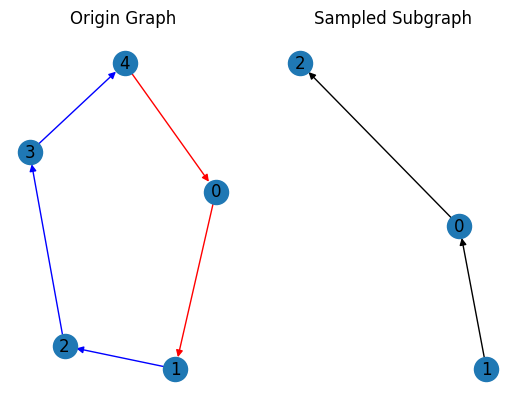

In [ ]:
sg = dgl.edge_subgraph(g, [0, 4])
display_graph(g, sg, "edge")
display_info(g, sg)

另外在 `edge_subgraph` 又可以細分為 `in_subgraph`，`out_subgraph`，`khop_in_subgraph` 和 `khop_out_subgraph`

#### in_subgraph

`in_subgraph` 根據節點 ID 去取出子圖，用法如下

`in_subgraph(graph, nodes)`
   - `graph:` 要取出的原圖
   - `nodes:` 要取出的節點 ID (只取出以 `nodes` 為 dst 的節點)

Origin Graph: Graph(num_nodes=5, num_edges=5,
      ndata_schemes={}
      edata_schemes={})
Sampled Subgraph: Graph(num_nodes=5, num_edges=2,
      ndata_schemes={}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})
Subgraph node IDs: tensor([0, 1, 2, 3, 4])
Original edge IDs: tensor([1, 4])


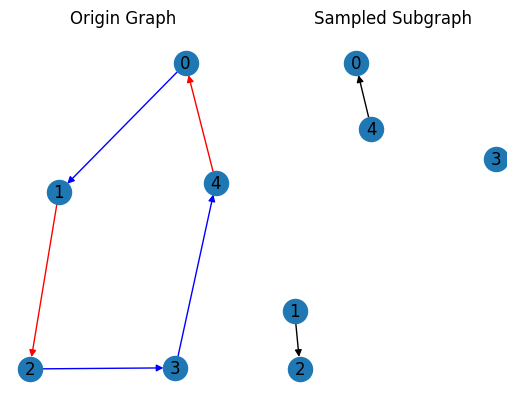

In [ ]:
sg = dgl.in_subgraph(g, [2, 0])
display_graph(g, sg, "edge")
display_info(g, sg)

#### out_subgraph

`out_subgraph` 根據節點 ID 去取出子圖，用法如下

`out_subgraph(graph, nodes)`
   - `graph:` 要取出的原圖
   - `nodes:` 要取出的節點 ID (只取出以 `nodes` 為 src 的節點)

Origin Graph: Graph(num_nodes=5, num_edges=5,
      ndata_schemes={}
      edata_schemes={})
Sampled Subgraph: Graph(num_nodes=5, num_edges=2,
      ndata_schemes={}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})
Subgraph node IDs: tensor([0, 1, 2, 3, 4])
Original edge IDs: tensor([2, 0])


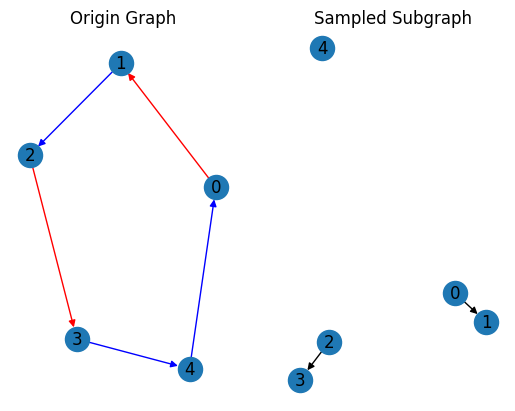

In [ ]:
sg = dgl.out_subgraph(g, [2, 0])
display_graph(g, sg, "edge")
display_info(g, sg)

#### khop_in_subgraph

`khop_in_subgraph` 根據節點 ID 與 k 近鄰取出子圖，用法如下

`khop_in_subgraph(graph, nodes, k)`
   - `graph:` 要取出的原圖
   - `nodes:` 要取出的節點 ID (只取出以 `nodes` 為 dst 的節點)
   - `k:` k 近鄰

Origin Graph: Graph(num_nodes=5, num_edges=5,
      ndata_schemes={}
      edata_schemes={})
Sampled Subgraph: Graph(num_nodes=3, num_edges=2,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})
Original node IDs: tensor([0, 3, 4])
Subgraph node IDs: tensor([0, 1, 2])
Original edge IDs: tensor([3, 4])


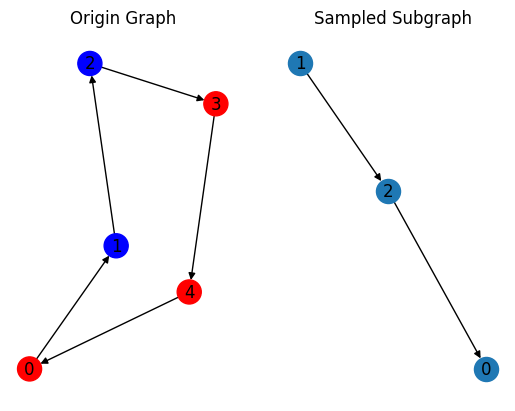

In [ ]:
sg, inverse_indices = dgl.khop_in_subgraph(g, 0, k=2)
display_graph(g, sg, "node")
display_info(g, sg)

#### khop_out_subgraph

`khop_in_subgraph` 根據節點 ID 與 k 近鄰取出子圖，用法如下

`khop_out_subgraph(graph, nodes, k)`
   - `graph:` 要取出的原圖
   - `nodes:` 要取出的節點 ID (只取出以 `nodes` 為 dst 的節點)
   - `k:` k 近鄰

Origin Graph: Graph(num_nodes=5, num_edges=5,
      ndata_schemes={}
      edata_schemes={})
Sampled Subgraph: Graph(num_nodes=3, num_edges=2,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})
Original node IDs: tensor([0, 1, 2])
Subgraph node IDs: tensor([0, 1, 2])
Original edge IDs: tensor([0, 1])


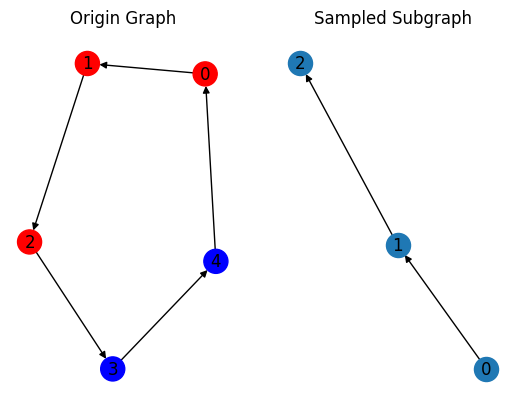

In [ ]:
sg, inverse_indices = dgl.khop_out_subgraph(g, 0, k=2)
display_graph(g, sg, "node")
display_info(g, sg)

其實每個 API 都可以用於異構圖上的採樣，並且還有 `node_type_subgraph` 和 `edge_type_subgraph` 兩個 API 專用於異構圖的採樣，不過我們這篇因為篇幅限制先不過多介紹了

## DataLoader

在工程實現上，一張圖的節點或邊的數量可能會多到無法一次進行整圖訓練，因此，我們會使用 sampler 對一張圖的節點和邊抽樣，抽出幾個批次的節點和邊進行訓練，這時候，我們就會需要使用 dgl 的 `DataLoader` 類

Note: `NodeDataLoader` 和 `EdgeDataLoader` 在 dgl 0.8 版本後已被棄用

- `DataLoader(graph, indices, graph_sampler, device=None, use_ddp=False, ddp_seed=0, batch_size=1, drop_last=False, shuffle=False)`
   - `graph:` dgl 圖類
   - `indices:` 要抽樣的資料 ID，只在 sampler 的 `__method__` 中會被調用
   - `graph_sampler:` 用什麼方式去做抽樣
   - `device:` 計算資源，"cpu" 或者 "cuda:rank"
   - `use_ddp:` 是否使用分布式系統訓練
   - `ddp_seed:` 分布式系統訓練隨機種子
   - `batch_size:` 每次抽樣資料筆數
   - `drop_last:` 當剩餘資料不足 `batch_size` 時，是否丟棄
   - `shuffle:` 打亂資料順序

### Sampler

在講講點抽樣與邊抽樣之前，我們先來看看有那些抽樣器，比較常用的有以下幾種

- `NeighborSampler(fanouts, edge_dir='in')`
   - `fanouts:->list` 列表長度代表 GNN layers 數量，列表中元素表示每層要抽樣多少個鄰居，例如 [5, 10, 15] 表示 GNN 共有 3 層，每層分別匯聚 5, 10, 15 個鄰居信息
   - `edge_dir:` 可選選項有 `in` 和 `out` 分別表示要從 in-degree 或者 out-degree 抽樣
- `MultiLayerFullNeighborSampler(num_layers)`
   - `num_layers:` GNN 共有幾層，該抽樣器會匯聚目標節點的所有鄰居信息

### 點抽樣

其實在工程實現上，盡管我們的計算資源可以支持整圖訓練，我們依然會使用 `DataLoader` 進行抽樣，其中又包含了對 node 或者 edge 進行抽樣，這兩者的用法稍有不同，以下我們來簡介點抽樣

In [ ]:
from dgl.dataloading import GraphDataLoader

[Block(num_src_nodes=27, num_dst_nodes=23, num_edges=46), Block(num_src_nodes=23, num_dst_nodes=16, num_edges=44), Block(num_src_nodes=16, num_dst_nodes=8, num_edges=31)]
[Block(num_src_nodes=27, num_dst_nodes=23, num_edges=46), Block(num_src_nodes=23, num_dst_nodes=16, num_edges=44), Block(num_src_nodes=16, num_dst_nodes=8, num_edges=31)]
[Block(num_src_nodes=26, num_dst_nodes=24, num_edges=47), Block(num_src_nodes=24, num_dst_nodes=17, num_edges=45), Block(num_src_nodes=17, num_dst_nodes=8, num_edges=20)]
[Block(num_src_nodes=30, num_dst_nodes=27, num_edges=54), Block(num_src_nodes=27, num_dst_nodes=16, num_edges=42), Block(num_src_nodes=16, num_dst_nodes=8, num_edges=19)]
[Block(num_src_nodes=24, num_dst_nodes=19, num_edges=38), Block(num_src_nodes=19, num_dst_nodes=14, num_edges=41), Block(num_src_nodes=14, num_dst_nodes=8, num_edges=27)]
[Block(num_src_nodes=20, num_dst_nodes=16, num_edges=32), Block(num_src_nodes=16, num_dst_nodes=9, num_edges=23), Block(num_src_nodes=9, num_dst_

[Block(num_src_nodes=27, num_dst_nodes=23, num_edges=46), Block(num_src_nodes=23, num_dst_nodes=16, num_edges=44), Block(num_src_nodes=16, num_dst_nodes=8, num_edges=31)]


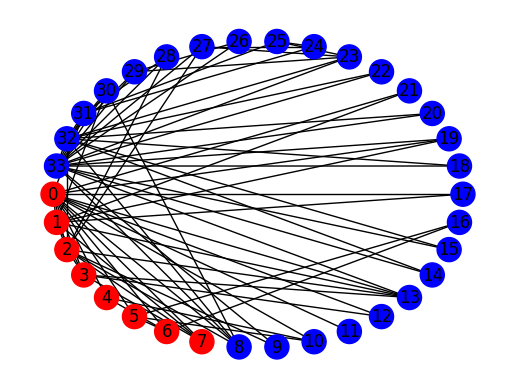

In [ ]:
import networkx as nx
import dgl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch
from dgl.dataloading import Sampler
from IPython.display import HTML
import warnings

warnings.filterwarnings("ignore")

def build_karate_club_graph():
    # add 34 nodes into the graph; nodes are labeled from 0~33
    # all 78 edges as a list of tuples
    edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]
    # add edges two lists of nodes: src and dst
    src, dst = tuple(zip(*edge_list))
    # for speed up, we transfer graph to int32
    g = dgl.graph((src, dst), idtype=torch.int64, num_nodes=34)
    # make Directed Acyclic Graph to Undirected Graph
    g = dgl.to_bidirected(g)

    return g


class SubgraphSampler(Sampler):
    def __init__(self):
        super().__init__()

    def sample(self, g, indices):
        return g.subgraph(indices)

g = build_karate_club_graph()
nxg = g.to_networkx().to_undirected()
fig, ax = plt.subplots()

# Function to update the graph in each frame of the animation
sampler = dgl.dataloading.NeighborSampler([2,3,4])
# sampler = dgl.dataloading.as_edge_prediction_sampler(sampler)
dataloader = dgl.dataloading.DataLoader(
    g, [i for i in range(34)], sampler,
    batch_size=8
)
# for input_nodes, output_nodes, block in dataloader:
#     print(input_nodes, output_nodes, block)
iterator = iter(dataloader)
def update(frame):
    # Get the list of indices for the current iteration
    ax.clear()
    try:
        # Get the list of indices for the current iteration
        input_nodes, output_nodes, block = frame
        print(block)
        pos = nx.shell_layout(nxg)
        nx.draw(nxg, pos, node_color=['red' if i in output_nodes else 'blue' for i in range(34)], with_labels=True)
    except StopIteration:
        animation.event_source.stop()  # 停止动画播放

# Create the animation
animation = FuncAnimation(fig, update, frames=iter(dataloader), interval=1000)  # Adjust interval as needed
# Save the animation as a GIF file
HTML(animation.to_jshtml())

#### Unpacking

dataloader 是個 Iterator，回傳 `(input_nodes, output_nodes, blocks)` 的元組

- `input_nodes:` 輸入節點的 ID，數量同 `blocks[0].number_of_src_nodes()`
- `output_nodes:` 要進行預測的節點 ID，數量同 `blocks[-1].number_of_dst_nodes()`
- `blocks:` 列表，`blocks[i]` 表示 GNN 中 $i$-layer 至 $(i+1)$-layer 的二分子圖

我們用一個簡單的例子帶大家了解 `blocks` 的工作原理

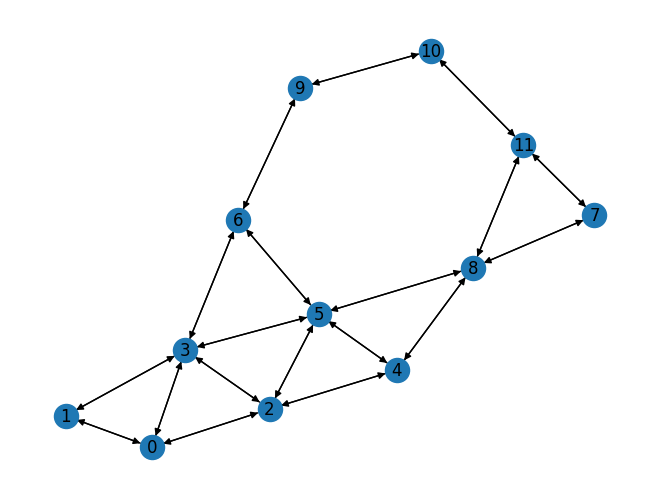

In [ ]:
import torch
import dgl

src = torch.LongTensor(
    [0, 0, 0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 7, 8, 9, 10,
     1, 2, 3, 3, 3, 4, 5, 5, 6, 5, 8, 6, 8, 9, 8, 11, 11, 10, 11])
dst = torch.LongTensor(
    [1, 2, 3, 3, 3, 4, 5, 5, 6, 5, 8, 6, 8, 9, 8, 11, 11, 10, 11,
     0, 0, 0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 7, 8, 9, 10])
g = dgl.graph((src, dst))
nxg = g.to_networkx()
nx.draw(nxg, with_labels=True)

從上圖看出，如果我們想要知道節點 8 的信息，我們必須匯聚 [4,5,7,11] 的節點信息，因此我們先取出所有指向節點 8 的子圖 (以節點 8 為 dst 的邊)

In [ ]:
frontier = dgl.in_subgraph(g, [8])
print(frontier)
print(frontier.all_edges())

Graph(num_nodes=12, num_edges=4,
      ndata_schemes={}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})
(tensor([ 4,  5,  7, 11]), tensor([8, 8, 8, 8]))


從上面的例子不難看出，我們只想知道節點 8 的信息，該節點只需要紀錄 [4,5,7,11] 節點信息即可，然而使用子圖方法會包含所有的節點，在計算中攜帶這些節點進行運算開銷是非常大的，因此我們透過 `block` 方法將輸入與輸出節點分為兩個點集合，形成一個局部的二分圖

![](https://data.dgl.ai/asset/image/guide_6_4_4.png)

Note: `block` 的輸入節點也會包含節點 8 的信息

以下是 `block` 常用的 API

In [ ]:
output_nodes = torch.LongTensor([8])
block = dgl.to_block(frontier, output_nodes)
print(block)
num_input_nodes, num_output_nodes = block.number_of_src_nodes(), block.number_of_dst_nodes()
block.srcdata['h'] = torch.randn(num_input_nodes, 5)
block.dstdata['h'] = torch.randn(num_output_nodes, 5)
print(block.srcdata['h'])
print(block.dstdata['h'])
# In DGL Block, the node ID will be rearrangement, therefore, we use dgl.NID to extract the raw node ID
input_nodes = block.srcdata[dgl.NID]
output_nodes = block.dstdata[dgl.NID]
assert torch.equal(input_nodes[:len(output_nodes)], output_nodes)
print(f"Number of input nodes: {num_input_nodes}")
print(f"Number of output nodes: {num_output_nodes}")
print(f"Input nodes NID: {input_nodes}")
print(f"Output nodes NID: {output_nodes}")

Block(num_src_nodes=5, num_dst_nodes=1, num_edges=4)
tensor([[-1.0878,  0.0884, -1.0075, -0.0954, -0.9116],
        [ 0.0162,  0.9850, -0.6778,  0.4725,  0.6871],
        [-0.3524,  0.5070,  0.8646,  1.4115,  0.2133],
        [ 0.2337, -0.9249,  0.8706,  0.6785, -0.4141],
        [ 0.1020,  0.9121, -1.3339,  0.2899,  0.0466]])
tensor([[-0.9234, -1.2424, -0.1704,  0.2467,  0.3802]])
Number of input nodes: 5
Number of output nodes: 1
Input nodes NID: tensor([ 8,  4,  5,  7, 11])
Output nodes NID: tensor([8])


#### Multi-Layer Block

我們一開始說到 `block` 是 GNN 網路中兩層之間連接的區塊，要是我們的網路是多層的呢?

從上面的例子看來，假設我們想要預設節點 8，我們必須在 GNN 的最後一層輸入節點 [4,5,7,8,11]，那麼在倒數第 2 層就必須匯聚 [4,5,7,8,11]的鄰居信息

Recall: $k$-layer 的 GNN 等同於在圖上遊走 $k$ 步

Note: 在 `block` 之間可以攜帶孤立點 (例如節點 3)

In [ ]:
# 节点3是一个孤立节点，没有任何指向它的边.
frontier2 = dgl.in_subgraph(g, [4,5,7,8,11,3])
block2 = dgl.to_block(frontier2, torch.LongTensor([4, 5, 7, 8, 11, 3]))
input_nodes = block2.srcdata[dgl.NID]
output_nodes = block2.dstdata[dgl.NID]
num_input_nodes, num_output_nodes = block2.number_of_src_nodes(), block2.number_of_dst_nodes()
print(f"Number of input nodes: {num_input_nodes}")
print(f"Number of output nodes: {num_output_nodes}")
print(f"Input nodes NID: {input_nodes}")
print(f"Output nodes NID: {output_nodes}")

Number of input nodes: 11
Number of output nodes: 6
Input nodes NID: tensor([ 4,  5,  7,  8, 11,  3,  2,  6, 10,  0,  1])
Output nodes NID: tensor([ 4,  5,  7,  8, 11,  3])


### 邊抽樣

同點抽樣，都是使用 `DataLoader` API，唯一不同的點是輸入 `sampler` 必須是對邊進行抽樣的 `sampler`，在實例化 `DataLoader` 物件後，我們可以使用 `as_edge_prediction_sampler` API 去把 `sampler` 轉成對邊進行抽樣的 `sampler`

- `as_edge_prediction_sampler(sampler, exclude=None, reverse_eids=None, reverse_etypes=None)`
   - `sampler:` 對邊進行抽樣的 sampler
   - `exclude:->str` 可選選項有 `self`, `reverse_id`, `reverse_types`
   - `exclude_eids:` 要排除的邊 ID
   - `exclude_etypes:` 要排除的邊型態

#### Unpacking

dataloader 是個 Iterator，回傳 `(input_nodes, pair_graph, blocks)` 的元組

- `input_nodes:` 輸入節點的 ID，數量同 `blocks[0].number_of_src_nodes()`
- `pair_graph:` 抽樣邊的子圖 (edge subgraphs)
- `blocks:` 列表，`blocks[i]` 表示 GNN 中 $i$-layer 至 $(i+1)$-layer 的二分子圖

In [ ]:
E = int(g.num_edges() // 2)
reverse_eids = torch.cat([torch.arange(E, 2 * E), torch.arange(0, E)])
# reverse_eids = torch.tensor([0,1,2])
sampler = dgl.dataloading.NeighborSampler([2,3])
sampler = dgl.dataloading.as_edge_prediction_sampler(sampler, exclude='reverse_id', reverse_eids=reverse_eids)
dataloader = dgl.dataloading.DataLoader(
    g, [i for i in range(E)], sampler,
    batch_size=8
)
next(iter(dataloader))

[tensor([0, 1, 2, 3, 4, 5, 6, 8, 9]),
 Graph(num_nodes=6, num_edges=8,
       ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}),
 [Block(num_src_nodes=9, num_dst_nodes=8, num_edges=8),
  Block(num_src_nodes=8, num_dst_nodes=6, num_edges=5)]]

tensor([0, 1, 2, 3, 4, 5, 8, 6, 7, 9]) Graph(num_nodes=6, num_edges=8,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}) [Block(num_src_nodes=10, num_dst_nodes=8, num_edges=7), Block(num_src_nodes=8, num_dst_nodes=6, num_edges=4)]
tensor([0, 1, 2, 3, 4, 5, 8, 6, 7, 9]) Graph(num_nodes=6, num_edges=8,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}) [Block(num_src_nodes=10, num_dst_nodes=8, num_edges=7), Block(num_src_nodes=8, num_dst_nodes=6, num_edges=4)]
tensor([ 3,  4,  5,  6,  7,  8,  9, 11,  0,  2, 10,  1]) Graph(num_nodes=8, num_edges=8,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}) [Block(num_src_nodes=12, num_dst_nodes=11, num_edges=13), Block(num_src_nodes=11, num_dst_nodes=8, num_edges=10)]
tensor([ 8,  9, 10, 11,  5,  7,  4,  6,  2

tensor([0, 1, 2, 3, 4, 5, 8, 6, 7, 9]) Graph(num_nodes=6, num_edges=8,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}) [Block(num_src_nodes=10, num_dst_nodes=8, num_edges=7), Block(num_src_nodes=8, num_dst_nodes=6, num_edges=4)]


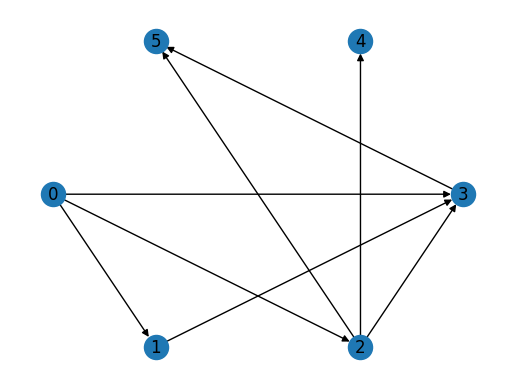

In [ ]:
fig, ax = plt.subplots()
def update(frame):
    # Get the list of indices for the current iteration
    ax.clear()
    try:
        # Get the list of indices for the current iteration
        idx, (input_nodes, pair_graph, blocks) = frame
        print(input_nodes, pair_graph, blocks)
        nxg = pair_graph.to_networkx()
        pos = nx.shell_layout(nxg)
        nx.draw(nxg, pos, with_labels=True)
        plt.savefig(f"filename{idx}.png")
    except StopIteration:
        animation.event_source.stop()  # 停止动画播放

# Create the animation
animation = FuncAnimation(fig, update, frames=enumerate(iter(dataloader)), interval=1000)  # Adjust interval as needed
# Save the animation as a GIF file
HTML(animation.to_jshtml())